# SRIMAX Model

## Content
* Elements
* Data Preprocessing
* Model Identification
* Model Estimation
* Model Verification
* Model Use

Import required tools

In [2]:
import time
import itertools
import joblib
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels as sm
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Get required config

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
# Show all columns ans rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Preprocessing

### Load data

In [4]:
# Load data
loading_path = r'/Users/rlg/Desktop/Workspace/data/df_inflation.csv'
df = pd.read_csv(loading_path)
df.head()

,DS,INFLACION,MXN/USD,AG_MONET_M2,TASA_INT,REMESAS,SM_NOM_GENERAL,SM_NOM_ZLFN,PIB_PCONST_VAR_ANUAL_TRIM
0,1/1/2021,3.54,19.9215,10434950530,4.30,3392808480,141.7,213.39,-2.594806
1,2/1/2021,3.76,20.3097,10406909432,4.11,3264101525,141.7,213.39,-2.594806
2,3/1/2021,4.67,20.7555,10516385860,4.02,4275093702,141.7,213.39,-2.594806
3,4/1/2021,6.08,20.0153,10517260240,4.01,4167759579,141.7,213.39,22.702244
4,5/1/2021,5.89,19.9631,10535614830,4.04,4677325083,141.7,213.39,22.702244


In [5]:
## Basic data manipulations
# Make sure dates are fine
df['DS'] = pd.to_datetime(df['DS'], format='mixed')
# Change column names
df = df.rename(columns = {'DS' : 'ds', 'INFLACION' : 'y'})
# Separate exogenous and endogenous variables
df_endog = df[['ds', 'y']]
df_exog = df.drop(columns = ['y'])


## For endogenous variable
# Get required dates
df_endog = df_endog[df_endog['ds'] < '2025-01-01']
df_endog_future = df_endog[df_endog['ds'] >= '2025-01-01'] # For forecast evaluation
# Set endogenous data
endog = pd.Series(df_endog['y'].values, index = df_endog['ds'], name = 'y')
endog_future = pd.Series(df_endog_future['y'].values, index = df_endog_future['ds'])


## For exogenous variables
# Normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
exog = pd.DataFrame(
    scaler.fit_transform(df_exog.drop(columns = ['ds'])),
    columns = ['MXN/USD', 'AG_MONET_M2', 'TASA_INT', 'REMESAS', 'SM_NOM_GENERAL', 'SM_NOM_ZLFN', 'PIB_PCONST_VAR_ANUAL_TRIM'],
    index = df_exog['ds']
)
# Get required dates
exog = exog[exog.index < '2025-01-01']
exog_future = exog[exog.index >= '2025-01-01'] # Proyections in order to forecast

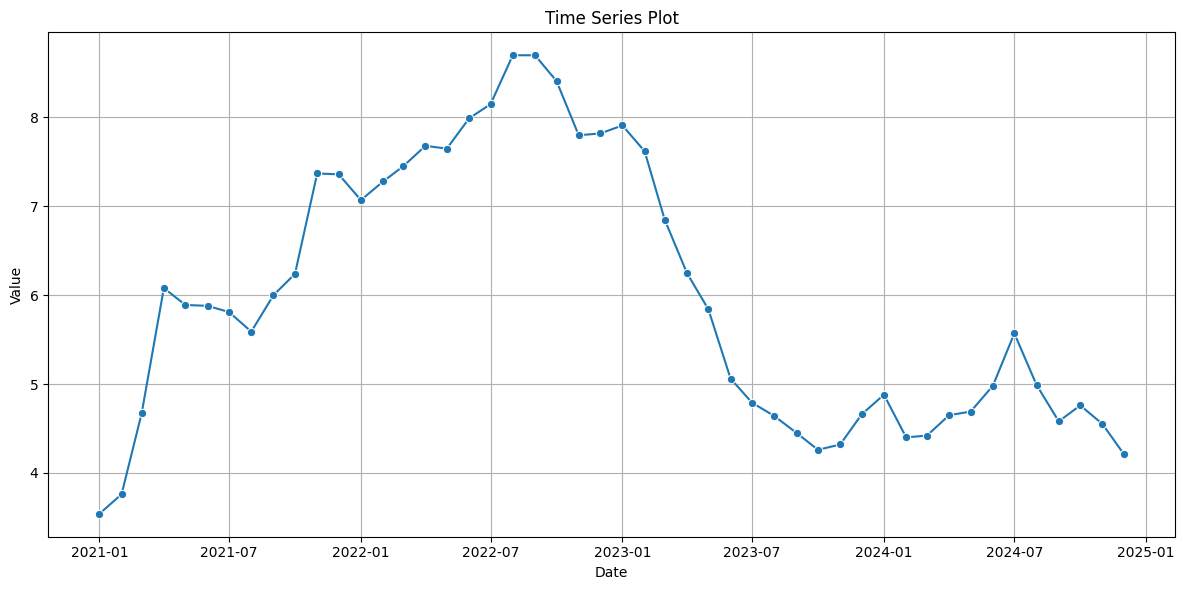

In [6]:
# Plot endogenous variable
plt.figure(figsize=(12, 6))
sns.lineplot(data = endog, marker = 'o')
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

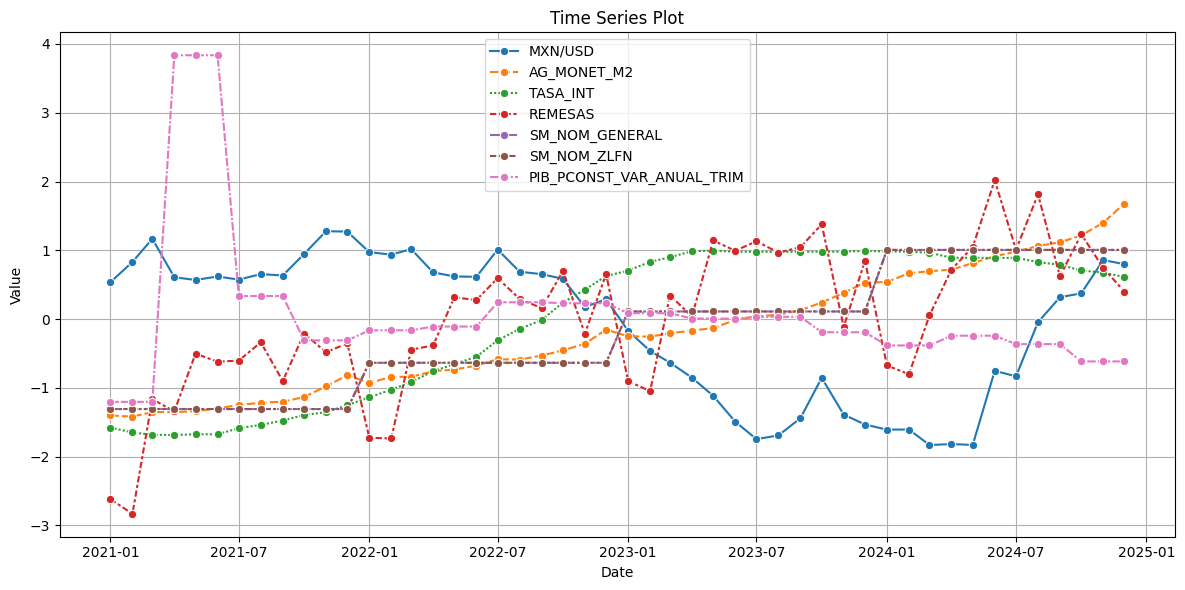

In [7]:
# Plot exogenous variables
plt.figure(figsize=(12, 6))
sns.lineplot(data = exog, marker = 'o')
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

### Seasonality Determination

**Seasonality determination by visual inspection**  
The goal is to look for patterns or repetitive cycles that recur at regular intervals. Check if there are obvious seasonal fluctuations.

In [ ]:
# Plot data
plt.figure(figsize=(18, 10))
sns.lineplot(data = endog, marker = 'o')
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.xticks(endog.index, rotation=45, fontsize = 8)
plt.tight_layout()
plt.show()

**Time Series Decomposition**  
The decomposition of time series assumes that the time series is composed of three main components: trend-cycle, which represents the long-term movement of the series; seasonality, which captures effects repeated annually with some consistency; and irregularity, which characterizes unpredictable and considered random movements. We'll focus in the seasonal part. 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

## Decompose the time series
# 52 for weekly time series
# 12 for monthly time series
# 4 for quarterly time series
result = seasonal_decompose(endog, model='additive', period = 12) 

plt.figure(figsize=(14, 8), dpi=100)
plt.plot(result.seasonal)
plt.grid(True)
plt.xticks(endog.index, rotation=45, fontsize = 8)
plt.title('Seasonality')
plt.show()

**ACP**  
Use the ACF to detect seasonal periods by identifying regular patterns or peaks. 
* In the ACF plot, significant peaks at regular intervals indicate the presence of seasonality. For example, if your data is monthly and you see peaks every 12 lags, this suggests a seasonal period of 12 months.
* The pattern of peaks will repeat with the seasonal period. For instance, if the ACF has a peak at lag 12, 24, 36, etc., this implies a seasonal period of 12.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF
plt.figure(figsize=(28, 16))  
plot_acf(endog, lags = endog.shape[0] - 1) 

# Customize x-axis ticks
plt.xticks(range(0, endog.shape[0], 12), rotation=45, fontsize=8)

plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

### Relevance Analysis for Exogenous Variables (Before Training)

In [8]:
# Set data
df_present = pd.concat([endog, exog], axis = 1)
endog_var = endog.name
exog_vars = exog.columns
df_present.head()

,y,MXN/USD,AG_MONET_M2,TASA_INT,REMESAS,SM_NOM_GENERAL,SM_NOM_ZLFN,PIB_PCONST_VAR_ANUAL_TRIM
ds,,,,,,,,
2021-01-01,3.54,0.537312,-1.400679,-1.578209,-2.617972,-1.307174,-1.30758,-1.203132
2021-02-01,3.76,0.830985,-1.417499,-1.648139,-2.830033,-1.307174,-1.30758,-1.203132
2021-03-01,4.67,1.168233,-1.351830,-1.681264,-1.164296,-1.307174,-1.30758,-1.203132
2021-04-01,6.08,0.608271,-1.351305,-1.684945,-1.341143,-1.307174,-1.30758,3.835016
2021-05-01,5.89,0.568782,-1.340296,-1.673903,-0.501570,-1.307174,-1.30758,3.835016


**Correlation Analysis**  
This analysis covers the following:
* Pearson and Spearman correlation of each exogenous variable with endogenous variable in order to get linear or non-linear relationships, respectively. 
* Pearson and Spearman correlation of each exogeonus variable eith each other in order to avoid multicollinearity.

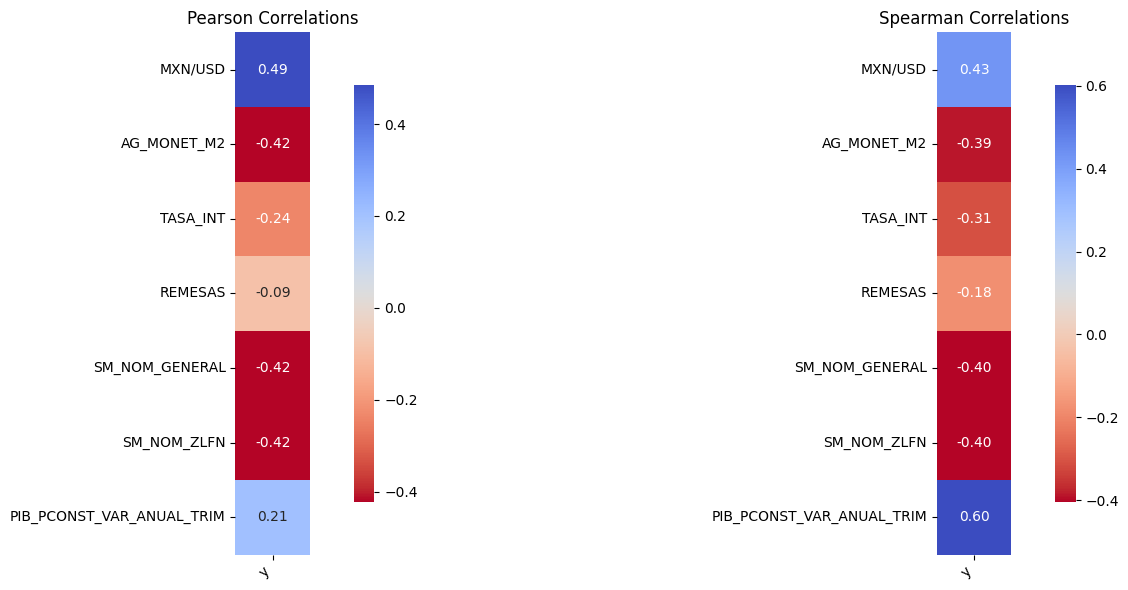

In [ ]:
# Pearson ans Spearman correlation for each exogenous variable with endogenous variable
corr_pearson = pd.DataFrame(df_present.corr(method='pearson').iloc[0, 1:])
corr_spearman = pd.DataFrame(df_present.corr(method='spearman').iloc[0, 1:])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson heatmap
sns.heatmap(corr_pearson, ax=axes[0], annot=True, cmap='coolwarm_r',
            fmt='.2f', square=True, cbar_kws={"shrink": .8})
axes[0].set_title('Pearson Correlations')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Spearman heatmap
sns.heatmap(corr_spearman, ax=axes[1], annot=True, cmap='coolwarm_r',
            fmt='.2f', square=True, cbar_kws={"shrink": .8})
axes[1].set_title('Spearman Correlations')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()


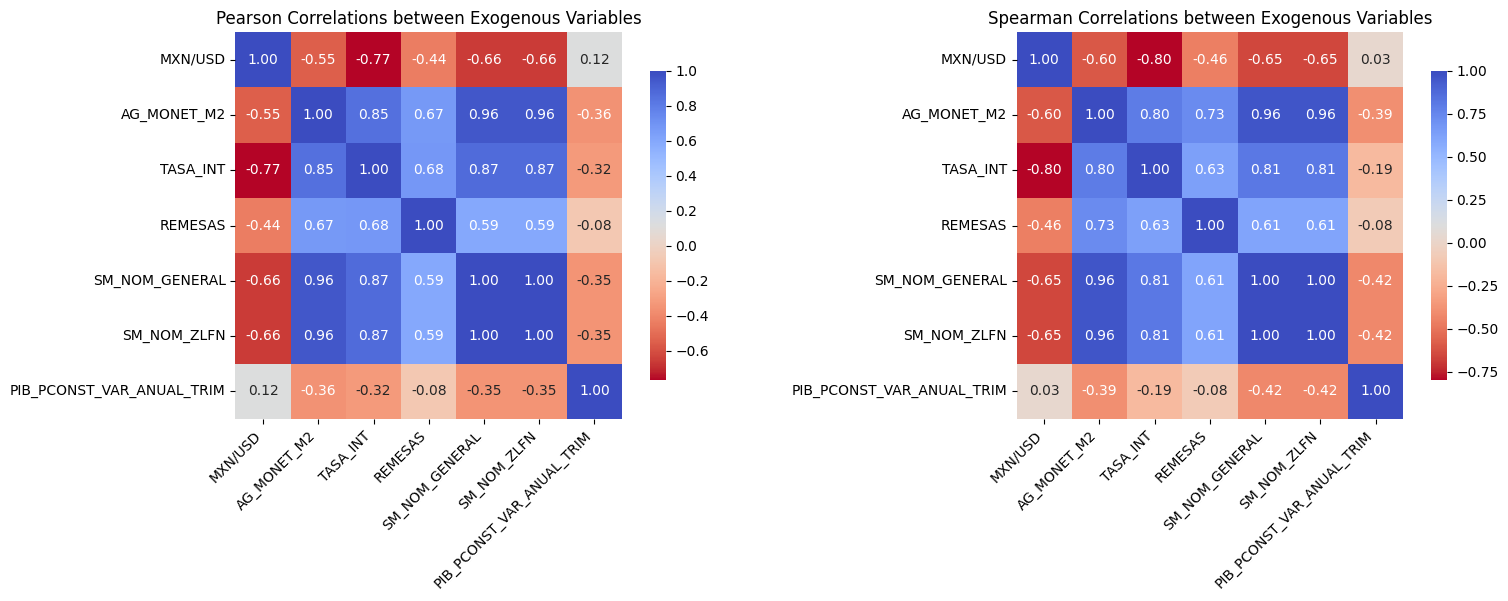

In [15]:
# Pearson and Spearman correlations between exogenous variables
corr_exog_pearson  = df_present[exog_vars].corr(method='pearson')
corr_exog_spearman = df_present[exog_vars].corr(method='spearman')

# Create subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson heatmap
sns.heatmap(corr_exog_pearson, ax=axes[0], annot=True, cmap='coolwarm_r',
            fmt='.2f', square=True, cbar_kws={"shrink": .8})
axes[0].set_title('Pearson Correlations between Exogenous Variables')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Spearman heatmap
sns.heatmap(corr_exog_spearman, ax=axes[1], annot=True, cmap='coolwarm_r',
            fmt='.2f', square=True, cbar_kws={"shrink": .8})
axes[1].set_title('Spearman Correlations between Exogenous Variables')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()


**Lagged Cross-Correlation**  
Consider time series $\{Y_t\}$ -endogenous variable- and $\{X_t\}$ -exogenous variable-. The lagged cross-correlation refers to calcule $corr(Y_t, X_{t-p})$ for $p\in\mathbb{N}$, typically using $p = 1,2,3$ in order to see how the lagged variable $X_{t-p}$ is related to $Y_t$. 

In [16]:
# Function to calculate lagged correlations
def past_lag_correlations(exog, endog, exog_lags = [1, 2, 3]):
    """
    Compute correlations between lagged exogenous variables and endogenous variable.
    
    Parameters:
        exog : Exogenous variables, indexed by timestamp (pd.DataFrame)
        endog : Endogenous variable, indexed by timestamp (pd.Series)
        exog_lags : List of integer lags to compute (list)
        
    Returns:
        corr_exog_perarson_lagged: Pearson correlation matrix with lags as rows and exog variable names as columns (pd.DataFrame)
        corr_exog_spearman_lagged: Spearman correlation matrix with lags as rows and exog variable names as columns (pd.DataFrame)
    """
    corr_pearson_lagged = pd.DataFrame(index = exog_lags, columns = exog.columns)
    corr_spearman_lagged = pd.DataFrame(index = exog_lags, columns = exog.columns)


    for lag in exog_lags:
        # Lag all exogenous variables by `lag` steps into the past
        exog_lagged = exog.shift(lag)
        
        # Align lagged exog and endog on timestamps, drop missing data
        df_aux = pd.concat([endog, exog_lagged], axis=1).dropna()
        
        # Compute correlation between endog and each lagged exog column
        for col in exog.columns:
            corr_pearson = df_aux[endog.name].corr(df_aux[col], method = 'pearson' )
            corr_pearson_lagged.at[lag, col] = corr_pearson
            corr_spearman = df_aux[endog.name].corr(df_aux[col], method = 'spearman')
            corr_spearman_lagged.at[lag, col] = corr_spearman
            

    return corr_pearson_lagged, corr_spearman_lagged

In [17]:
# Calculate lagged correlations
corr_pearson_lagged, corr_spearman_lagged = past_lag_correlations(exog = exog, endog = endog, exog_lags=[1, 2, 3])

In [ ]:
corr_per

**Regression Analysis**  
Consider time series $\{Y_t\}$ -endogenous variable- and $\{X_t\}$ -exogenous variable-. The regression analysis refers to run a simple regression $Y_t = X_{t-1} + X_{t-2},...,X_{t-p}$ with $p\in\mathbb{N}$, typically using $p = 1,2,3$, in order to get the statistical significance of the lagged exogenous variables regarding the endogenous variable through $t$-tests. Any $p$-value such that $p < 0.05$ suggests statistical significance, thus a relevant variable. Any other such that $p \geq 0.05$ suggest non-significance, thus an irrelevant variable. 

In [ ]:
# Function to run OLS regression with lagged exogenous variables
def ols_lagged_regression(endog: pd.Series, exog: pd.DataFrame, exog_lags=[1, 2, 3]):
    """
    Fit an OLS regression of endogenous variable on lagged exogenous variables.

    IN:
    -> exog : Exogenous variables, indexed by timestamp (pd.DataFrame)
    -> endog : Endogenous variable, indexed by timestamp (pd.Series)
    -> exog_lags : List of integer lags to compute (list)

    OUT:
    -> results (RegressionResultsWrapper): The fitted OLS model result
    """
    # Create lagged versions of exog variables
    X_lagged = pd.concat({
        f"{col}_lag{lag}": exog[col].shift(lag)
        for col in exog.columns
        for lag in exog_lags
    }, axis=1)
    print(X_lagged.head(20))

    # Combine and drop missing rows
    df_OLS = pd.concat([endog, X_lagged], axis=1).dropna()
    y = df_OLS[endog.name]
    X = df_OLS.drop(columns=[endog.name])

    # Add constant term
    X = sm.add_constant(X)

    # Fit OLS
    model = sm.OLS(y, X).fit()

    return model


Pre-training checks
* OLS regression
* Granger Causality Test
* Mutual Information
* Variance ans Stationarity Check   

Post-training checks
* Statistical significance
* Joint interactions amog variables
* True contribution to AIC/BIC 


In [ ]:
Option A: Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression